# This has many Fairness applications

Trying bias mitigation methods preprocessing, in dev and post processing

In [103]:
#---------------------------------- IMPORTANT PACKAGES --------------------------------------------#
print('-------------Importing Useful packages------------')
import numpy as np
import pandas as pd
from pandas import DataFrame as df
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt

# Data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from fairlearn.preprocessing import CorrelationRemover

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Metrics
# fairness
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, equalized_odds_ratio, demographic_parity_ratio, MetricFrame
from sklearn.metrics import ConfusionMatrixDisplay,classification_report,roc_auc_score, RocCurveDisplay, recall_score, precision_score, f1_score, balanced_accuracy_score, confusion_matrix

# Bias Mitigation
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import ExponentiatedGradient, DemographicParity

# Explainability
import shap


-------------Importing Useful packages------------


In [78]:
#----------------------------------- DATA LOADING -------------------------------------------#
print('-----------------Reading CSV file into dataframe-------------------')
data = pd.read_csv('./heart.csv')

-----------------Reading CSV file into dataframe-------------------


## Preprocessing
This includes:
* Removing outlier leaving 917 observations
* Change age numerical data to ranged categories.
* Numerical data scaling
* Categorical data encoding
* Spliting data

Maybe changing age data to ranged categories.

Have data for preprocessing


In [79]:
#----------------------------------- DATA PREPROCESSING -------------------------------------------#
print('-------------------Preprocessing-------------------------')
# Outliers
data= data[data['RestingBP'] > 0]

# Scaling
robust_scale = RobustScaler()
standard_scale = StandardScaler()
minmax_scaler = MinMaxScaler()
# Encoding
ohe= OneHotEncoder()
le = LabelEncoder()

data['Sex'] = le.fit_transform(data['Sex'])
data['ChestPainType'] = le.fit_transform(data['ChestPainType'])
data['RestingECG'] = le.fit_transform(data['RestingECG'])
data['ExerciseAngina'] = le.fit_transform(data['ExerciseAngina'])
data['ST_Slope'] = le.fit_transform(data['ST_Slope'])
data['Age'] = np.where(data['Age'].between(0,40), 0, data['Age']) # Young
data['Age'] = np.where(data['Age'].between(41,60), 1, data['Age']) # Middle Aged
data['Age'] = np.where(data['Age'].between(61,77), 2, data['Age']) # Seniors

# Scaling Numerical Data
data['Oldpeak'] = robust_scale.fit_transform(data[['Oldpeak']])
# data['Age'] = robust_scale.fit_transform(data[['Age']])
data['RestingBP'] = robust_scale.fit_transform(data[['RestingBP']])
data['Cholesterol'] = robust_scale.fit_transform(data[['Cholesterol']])
data['MaxHR'] = robust_scale.fit_transform(data[['MaxHR']])


-------------------Preprocessing-------------------------


In [80]:
#----------------------------------- SPLIT DATA -------------------------------------------#
print('------------Spliting Data------------')
target= data['HeartDisease']
features= data.drop('HeartDisease', axis=1)
x_dev, x_test, y_dev, y_test = train_test_split(features, target, test_size = 0.20, random_state = 0)

------------Spliting Data------------


# Correlation testing

alpha 1 had empty x values
https://fairlearn.org/main/auto_examples/plot_correlationremover_before_after.html

What does a correlation remover do? https://holisticai.readthedocs.io/en/latest/getting_started/bias/mitigation/preprocessing/bc_correlation_remover_correlationremover.html

In [81]:
print('---------------------------------Applying Preprocessing for fairness: Correlation removal---------------------------')
sensitive_features = ['Age', 'Sex']

# Remove correlation between sensitive features and other features
cr = CorrelationRemover(sensitive_feature_ids=sensitive_features)
x_cr = cr.fit_transform(features)
x_cr_fair=pd.DataFrame(x_cr, columns=['ChestPainType',  'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
#x_cr_fair[sensitive_features]=features[sensitive_features]
# Create new training data with reduced bias
x_dev_fair, x_test_fair, y_dev_fair, y_test_fair = train_test_split(x_cr_fair, target, test_size = 0.20, random_state = 0)

# # Sex
# cr_sex = CorrelationRemover(sensitive_feature_ids=["Sex"])
# X_cr_sex = cr_sex.fit_transform(features)
# X_cr_sex = pd.DataFrame(X_cr_sex, columns=['Age', 'ChestPainType',  'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
# X_cr_sex["Sex"] = features["Sex"]

# x_dev_sex, x_test_sex, y_dev_sex, y_test_sex = train_test_split(X_cr_sex, target, test_size = 0.20, random_state = 0)

# #Age
# cr_age = CorrelationRemover(sensitive_feature_ids=["Age"])
# X_cr_age = cr_age.fit_transform(features)
# X_cr_age = pd.DataFrame(X_cr_age, columns=['Sex', 'ChestPainType',  'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'])
# X_cr_age["Age"] = features["Age"]
# x_dev_age, x_test_age, y_dev_age, y_test_age = train_test_split(X_cr_age, target, test_size = 0.20, random_state = 0)


---------------------------------Applying Preprocessing for fairness: Correlation removal---------------------------


In [ ]:
sns.heatmap(features.corr())

In [ ]:
sns.heatmap(pd.DataFrame(x_cr_fair).corr())

In [ ]:
#-------------------------------------- PERFORMANCE METRICS ----------------------------------------#
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity
def performFair(sensitive_feature, y_test, y_pred):

    metric_frame = MetricFrame(
        metrics={
            "Recall or Sensitivity": recall_score,
            #"Specificity": specificity,
            "Precision": precision_score,
            "F1 Score": f1_score,
            "Balanced Accuracy": balanced_accuracy_score,
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features= sensitive_feature,
    )
    print('OVERALL METRICS')
    print(metric_frame.overall)
    print('METRIC BY GROUP')
    print(metric_frame.by_group)
    # print('CONFIDENCE INTERVALS')
    # print(metric_frame.by_group_ci)
    metric_frame.by_group.plot.bar(
        subplots=True,
        # x= ['Young Men', 'Young Women', 'Middle Aged Men', 'Middle Aged Women', 'Senior Men', 'Senior Women'],
        layout=[4, 1],
        legend=False,
        figsize=[12, 8],
        title="Accuracy and selection rate by group",
    )
    print('---------------------------------Both Sensitive Features Applied--------------------------------')
    dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_feature)
    dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_feature)
    print(f'The Demographic Parity Difference is: {dpd}')
    print(f'The Demographic Parity Ratio is: {dpr}')
    eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_feature)
    eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_feature)
    print(f'The Equalized Odds Difference is: {eod}')
    print(f'The Equalized Odds Ratio is: {eor}')


In [116]:
#-------------------------------------- PERFORMANCE METRICS ----------------------------------------#
# Metrics Function
def metrics(y_test, y_pred):
    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.show()
    
    # Precision, Recall, F1 score
    print(classification_report(y_test,y_pred))
    print(f'Specificity: ', {specificity(y_test, y_pred)})
    print(roc_auc_score(y_test,y_pred))

    # ROC
    RocCurveDisplay.from_predictions(y_test,y_pred)
    plt.title('ROC_AUC_Plot')
    plt.show()

#------------------------------------ FAIRNESS EVALUATION ------------------------------------------#
def fairness(x_test, y_test, y_pred):
    age_sensitive= x_test['Age']
    sex_sensitive = x_test['Sex']
    sensitive_features = ['Age', 'Sex']
    # Demographic Parity
    age_dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=age_sensitive)
    sex_dpd = demographic_parity_difference(y_test, y_pred, sensitive_features=sex_sensitive)
    age_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=age_sensitive)
    sex_dpr = demographic_parity_ratio(y_test, y_pred, sensitive_features=sex_sensitive)
    print(f'The Age Demographic Parity Difference is: {age_dpd}')
    print(f'The Age Demographic Parity Ratio is: {age_dpr}')
    print(f'The Sex Demographic Parity Difference is: {sex_dpd}')
    print(f'The Sex Demographic Parity Ratio is: {sex_dpr}')

    # equalized_odds
    age_eod = equalized_odds_difference(y_test, y_pred, sensitive_features=age_sensitive)
    sex_eod = equalized_odds_difference(y_test, y_pred, sensitive_features=sex_sensitive)
    age_eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=age_sensitive)
    sex_eor = equalized_odds_ratio(y_test, y_pred, sensitive_features=sex_sensitive)
    print(f'The Age Equalized Odds Difference is: {age_eod}')
    print(f'The Age Equalized Odds Ratio is: {age_eor}')
    print(f'The Sex Equalized Odds Difference is: {sex_eod}')
    print(f'The Sex Equalized Odds Ratio is: {sex_eor}')


In [85]:
#-------------------------------------EXPLAINABILITY--------------------------------------#
shap.initjs()
def explain(explainer, X_test):
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

## Build model and test
https://markaicode.com/ai-agent-bias-mitigation-fairlearn-2-toolkit-hr/
In process bias mitigation techniques

In [86]:
#
def modelEstimator(classifier, x_train, y_train, x_test):
    sensitive_features = ['Age', 'Sex']
    # Define a new ML estimator that optimizes for fairness
    fair_estimator = ExponentiatedGradient(
        estimator=classifier,  # Your original ML model
        constraints=DemographicParity(),
        eps=0.1  # Fairness constraint violation tolerance
    )

    # Train the fair model
    fair_estimator.fit(
        x_train,
        y_train,
        sensitive_features= np.array(pd.DataFrame(x_train, columns=sensitive_features))
    )

    # POST PROCESSING

    # Create a threshold optimizer
    threshold_optimizer = ThresholdOptimizer(
        estimator=fair_estimator,
        constraints="demographic_parity",
        prefit=True
    )

    # Fit the optimizer
    threshold_optimizer.fit(
        x_train, y_train,
        sensitive_features= np.array(pd.DataFrame(x_train, columns=sensitive_features))
    )

    # Get fair predictions
    fair_predictions = threshold_optimizer.predict(
        x_test,
        sensitive_features= np.array(pd.DataFrame(x_test, columns=sensitive_features))
    )
    return threshold_optimizer, fair_predictions


In [122]:

#-------------------------------------- Model ----------------------------------------#
# in and post process mitiagation techniques
def model(classifier, x_dev, x_test, y_dev, y_test):
    kf=StratifiedKFold(n_splits=9)
    for fold , (train,validate) in enumerate(kf.split(X=x_dev,y=y_dev)):
        
        X_train=x_dev.iloc[train]
        y_train=y_dev.iloc[train]
        
        X_valid=x_dev.iloc[validate]
        y_valid=y_dev.iloc[validate]
        
        classifier.fit(X_train,y_train)
        
        y_pred=classifier.predict(X_valid)
        print(f"The fold is : {fold} : ")
        print(classification_report(y_valid,y_pred))
        acc=roc_auc_score(y_valid,y_pred)
        print(f"The accuracy for Fold {fold+1} : {acc}")
        fair_model, fair_pred = modelEstimator(classifier, X_train, y_train, X_valid)
        accf=roc_auc_score(y_valid,fair_pred)
        print(f"The FAIR accuracy for Fold {fold+1} : {accf}")
        pass
    print('-----------------------Base Model-------------------------')
    y_pred = classifier.predict(x_test)
    #performFair(x_test, y_test, y_pred)
    y_t = y_test.to_numpy()
    performFair(pd.DataFrame(x_test, columns=["Age", "Sex"]), y_t, y_pred)
    metrics(y_test, y_pred)
    # fairness(x_test, y_test, y_pred)
    print('-----------------------Fair Model-------------------------')
    fair_pred = fair_model.predict(x_test, sensitive_features=x_test[sensitive_features])
    #performFair(x_test, y_test, y_pred)
    performFair(pd.DataFrame(x_test, columns=["Age", "Sex"]), y_t, fair_pred)
    metrics(y_test, fair_pred)
    # fairness(x_test, y_test, fair_pred)
    return classifier, y_pred, fair_pred, fair_model
    
#--------------------------------------------------------------------------------------------------------#

In [90]:

#-------------------------------------- Model ----------------------------------------#
# pre processing mtigation techniques
def modelpre(classifier, x_dev, x_test, y_dev, y_test, xt):
    kf=StratifiedKFold(n_splits=9)
    for fold , (train,validate) in enumerate(kf.split(X=x_dev,y=y_dev)):
        
        X_train=x_dev.iloc[train]
        y_train=y_dev.iloc[train]
        
        X_valid=x_dev.iloc[validate]
        y_valid=y_dev.iloc[validate]
        
        classifier.fit(X_train,y_train)
        
        y_pred=classifier.predict(X_valid)
        print(f"The fold is : {fold} : ")
        print(classification_report(y_valid,y_pred))
        acc=roc_auc_score(y_valid,y_pred)
        print(f"The accuracy for Fold {fold+1} : {acc}")
        pass
    print('-----------------------Base Model-------------------------')
    y_pred = classifier.predict(x_test)
    #performFair(x_test, y_test, y_pred)
    metrics(y_test, y_pred)
    fairness(xt, y_test, y_pred)
    return classifier, y_pred
    
#--------------------------------------------------------------------------------------------------------#

In [ ]:
# Tree Explainer for random forest, Ada boost, Hist
ex = shap.TreeExplainer(dtree)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Explainer for KNN

# SVC, KNN, Neural use kernel explainers
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)


# Kernel explainer for neural network
explainer = shap.KernelExplainer(nn.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

ex = shap.KernelExplainer(lin_regr.predict, X_train_summary)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


OVERALL METRICS
Recall or Sensitivity    0.833333
Precision                0.809524
F1 Score                 0.821256
Balanced Accuracy        0.794715
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.166667
    1                 1.000000   0.666667  0.800000           0.909091
1   0                 0.750000   0.333333  0.461538           0.687500
    1                 0.790323   0.924528  0.852174           0.838018
2   0                 1.000000   0.666667  0.800000           0.916667
    1                 0.900000   0.931034  0.915254           0.825000
---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.45833333333333337
The Demographic Parity Ratio is: 0.44999999999999996
The Equalized Odds Difference is: 1.0
The

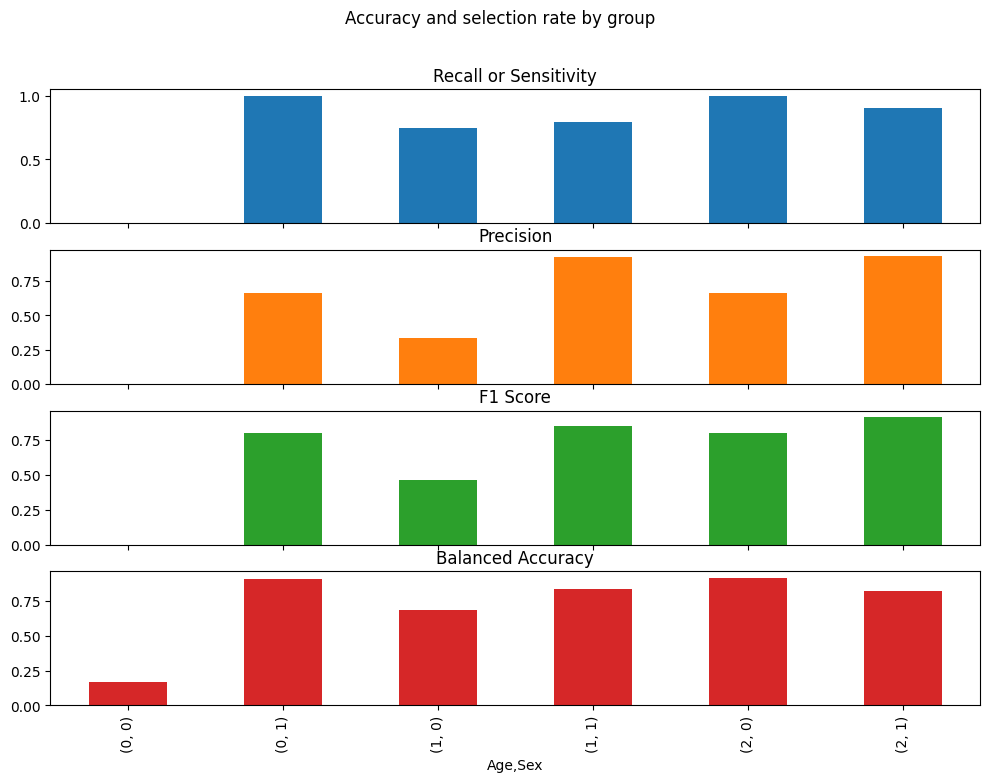

In [130]:
y_t = y_test.to_numpy()
performFair(pd.DataFrame(x_test, columns=["Age", "Sex"]), y_t, y_pred)

--------------------------Logistic Regression---------------------------------
--------------------------With CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.89      0.86        37
           1       0.90      0.84      0.87        45

    accuracy                           0.87        82
   macro avg       0.86      0.87      0.87        82
weighted avg       0.87      0.87      0.87        82

The accuracy for Fold 1 : 0.8681681681681682
The FAIR accuracy for Fold 1 : 0.7585585585585586
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 2 : 0.8165165165165165
The FAIR acc

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Demographic Parity Difference is: 0.9473684210526315
The Demographic Parity Ratio is: 0.0
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


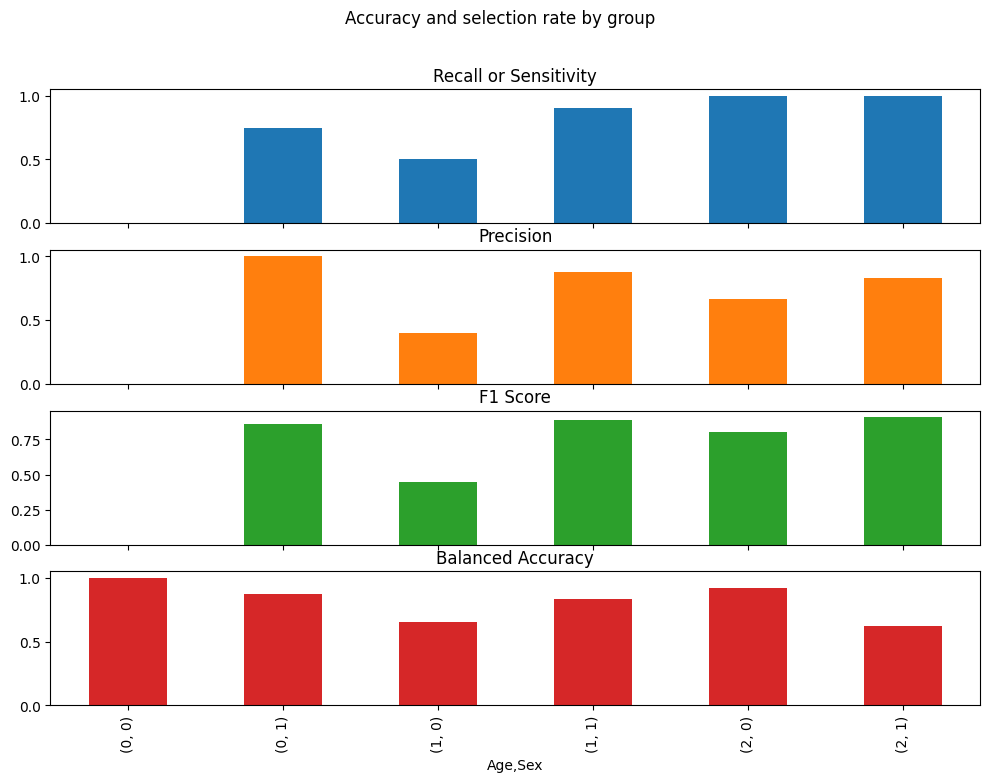

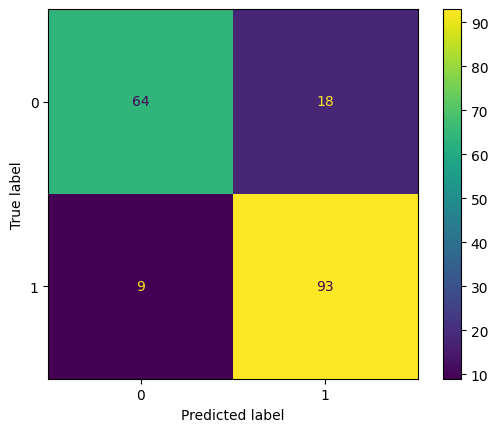

              precision    recall  f1-score   support

           0       0.88      0.78      0.83        82
           1       0.84      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.86      0.85      0.85       184
weighted avg       0.86      0.85      0.85       184

Specificity:  {0.7804878048780488}
0.8461262553802008


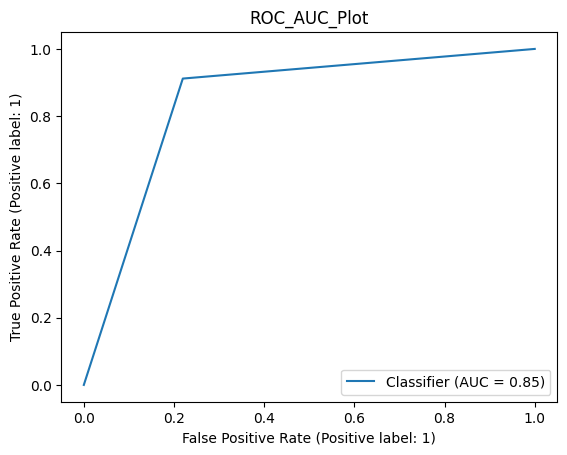

-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.803922
Precision                0.752294
F1 Score                 0.777251
Balanced Accuracy        0.737327
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.500000
    1                 1.000000   0.666667  0.800000           0.909091
1   0                 1.000000   0.250000  0.400000           0.625000
    1                 0.838710   0.866667  0.852459           0.805069
2   0                 1.000000   0.500000  0.666667           0.833333
    1                 0.666667   1.000000  0.800000           0.833333
---------------------------------Both Sensitive Features Applied--------------------------------


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


The Demographic Parity Difference is: 0.4
The Demographic Parity Ratio is: 0.5
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


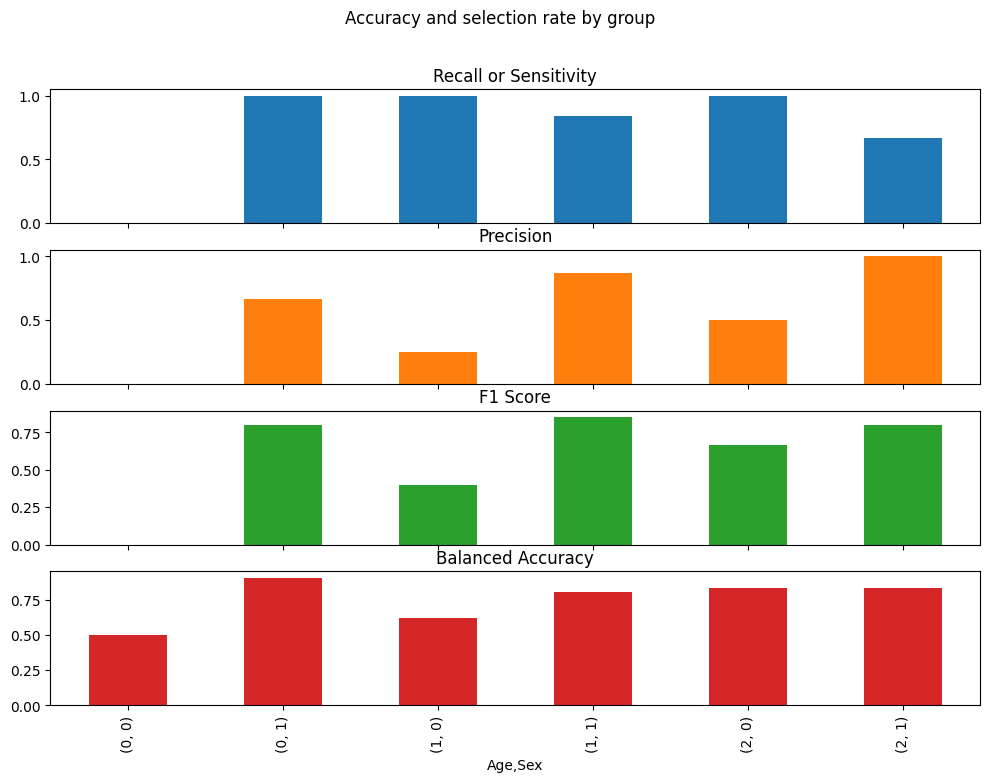

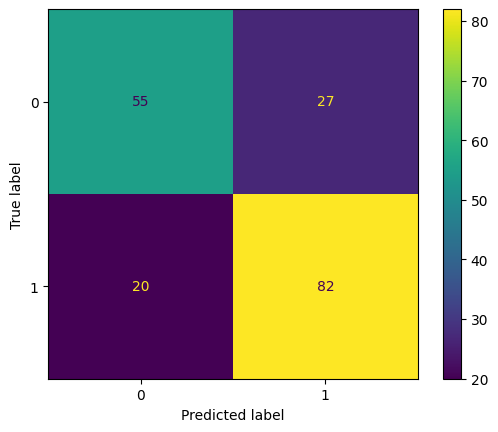

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        82
           1       0.75      0.80      0.78       102

    accuracy                           0.74       184
   macro avg       0.74      0.74      0.74       184
weighted avg       0.74      0.74      0.74       184

Specificity:  {0.6707317073170732}
0.737326637972262


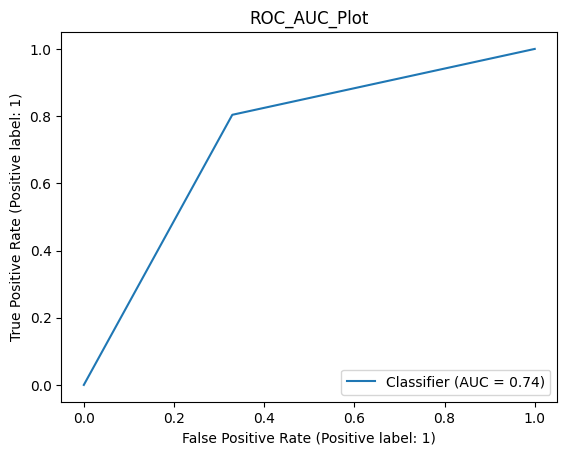

--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        37
           1       0.88      0.82      0.85        45

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

The accuracy for Fold 1 : 0.8435435435435436
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        37
           1       0.80      0.71      0.75        45

    accuracy                           0.74        82
   macro avg       0.75      0.75      0.74        82
weighted avg       0.75      0.74      0.74        82

The accuracy for Fold 2 : 0.7474474474474475
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        37
          

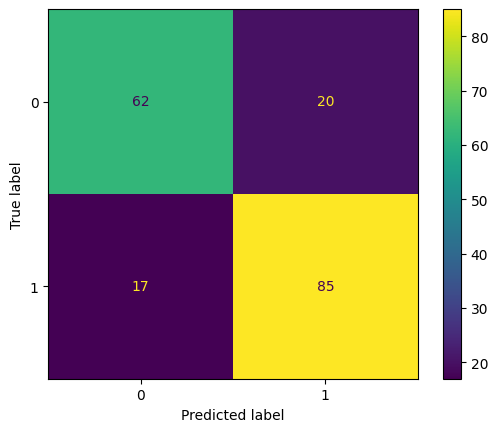

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        82
           1       0.81      0.83      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.79      0.80       184
weighted avg       0.80      0.80      0.80       184

Specificity:  {0.7560975609756098}
0.7947154471544715


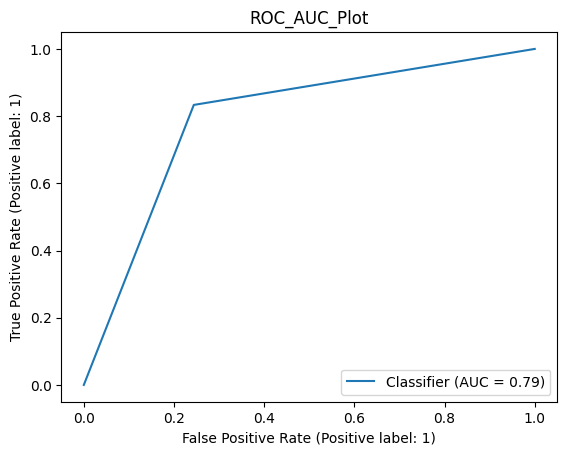

The Age Demographic Parity Difference is: 0.17184265010351962
The Age Demographic Parity Ratio is: 0.7529761904761906
The Sex Demographic Parity Difference is: 0.08666666666666667
The Sex Demographic Parity Ratio is: 0.8522727272727273
The Age Equalized Odds Difference is: 0.2156862745098039
The Age Equalized Odds Ratio is: 0.4761904761904762
The Sex Equalized Odds Difference is: 0.2804232804232804
The Sex Equalized Odds Ratio is: 0.345679012345679


In [131]:
#----------------------------------- LOGISTIC REGRESSION MODEL----------------------------#
print('--------------------------Logistic Regression---------------------------------')
print('--------------------------With CORRELATION----------------------------------')

classifier_lr, y_pred, fair_pred, fair_model= model(LogisticRegression(random_state = 0,C=10,penalty= 'l2'), x_dev, x_test, y_dev, y_test)
# explain(shap.Explainer(classifier_lr), x_test)
print('--------------------------Without CORRELATION----------------------------------')
classifier_lr_fair, y_pred= modelpre(LogisticRegression(random_state = 0,C=10,penalty= 'l2'), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

--------------------------Support Vector Matrix----------------------------------
--------------------------With CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.80      0.89      0.85        37
           1       0.90      0.82      0.86        45

    accuracy                           0.85        82
   macro avg       0.85      0.86      0.85        82
weighted avg       0.86      0.85      0.85        82

The accuracy for Fold 1 : 0.857057057057057
The FAIR accuracy for Fold 1 : 0.7204204204204205
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        37
           1       0.84      0.84      0.84        45

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82

The accuracy for Fold 2 : 0.8276276276276276
The FAIR a

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


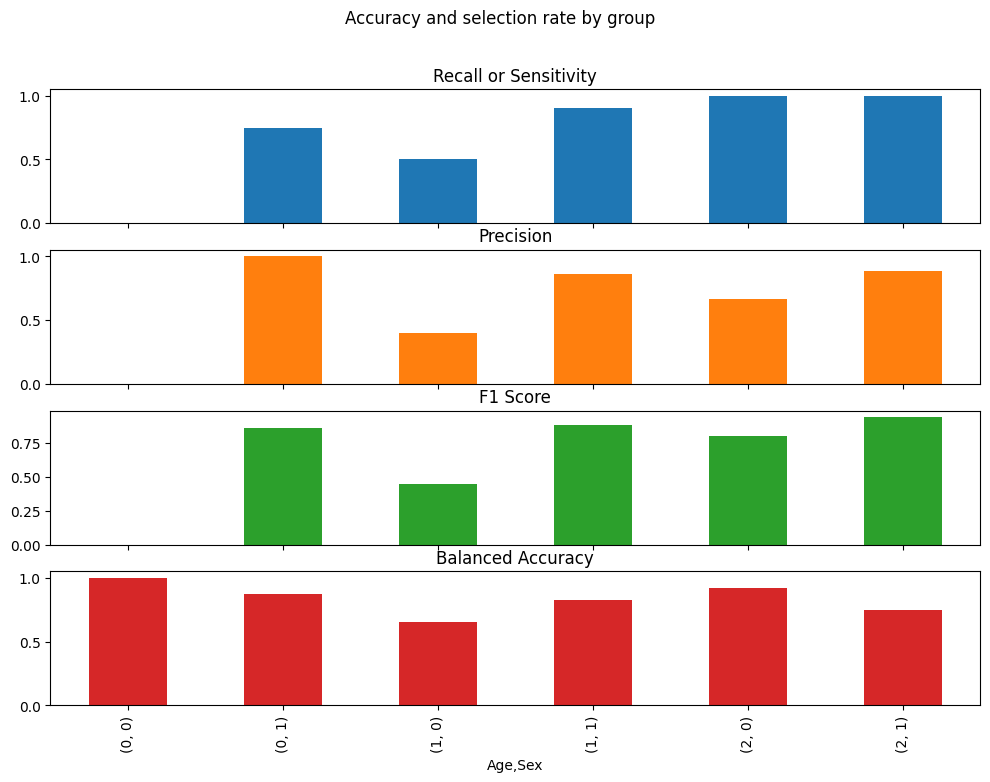

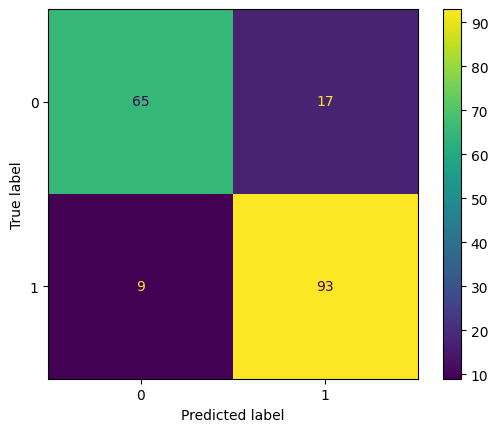

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Specificity:  {0.7926829268292683}
0.8522238163558106


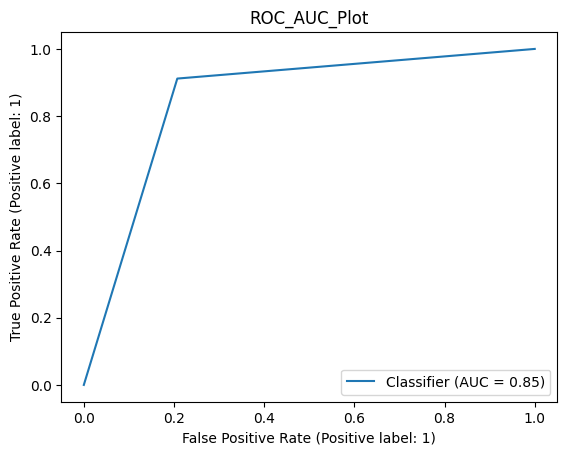

-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.784314
Precision                0.701754
F1 Score                 0.740741
Balanced Accuracy        0.684840
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.333333
    1                 1.000000   0.444444  0.615385           0.772727
1   0                 1.000000   0.266667  0.421053           0.656250
    1                 0.822581   0.850000  0.836066           0.782719
2   0                 0.500000   0.200000  0.285714           0.416667
    1                 0.666667   0.952381  0.784314           0.770833


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.19736842105263153
The Demographic Parity Ratio is: 0.736842105263158
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


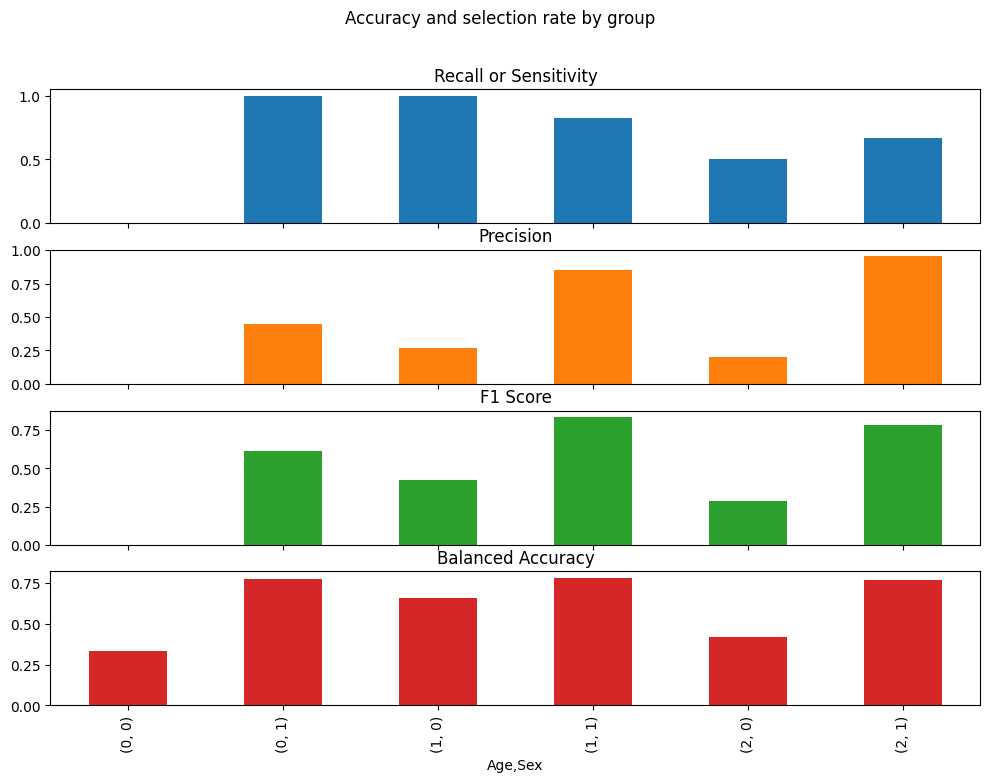

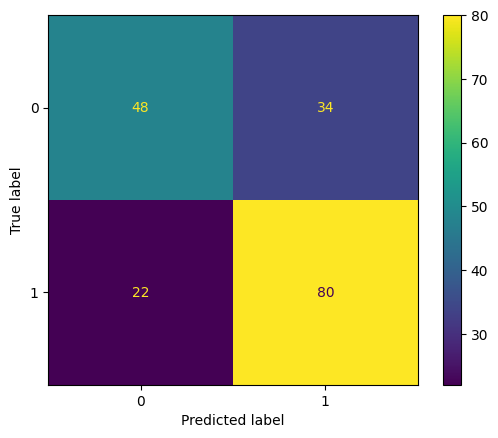

              precision    recall  f1-score   support

           0       0.69      0.59      0.63        82
           1       0.70      0.78      0.74       102

    accuracy                           0.70       184
   macro avg       0.69      0.68      0.69       184
weighted avg       0.69      0.70      0.69       184

Specificity:  {0.5853658536585366}
0.6848397895743663


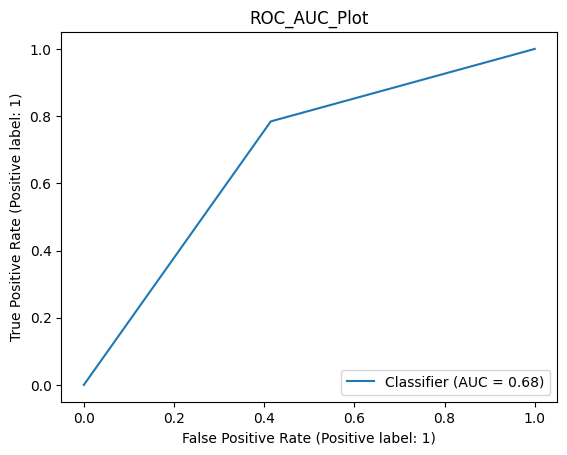

--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        37
           1       0.88      0.80      0.84        45

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82

The accuracy for Fold 1 : 0.8324324324324325
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        37
           1       0.82      0.71      0.76        45

    accuracy                           0.76        82
   macro avg       0.76      0.76      0.76        82
weighted avg       0.77      0.76      0.76        82

The accuracy for Fold 2 : 0.760960960960961
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        37
           

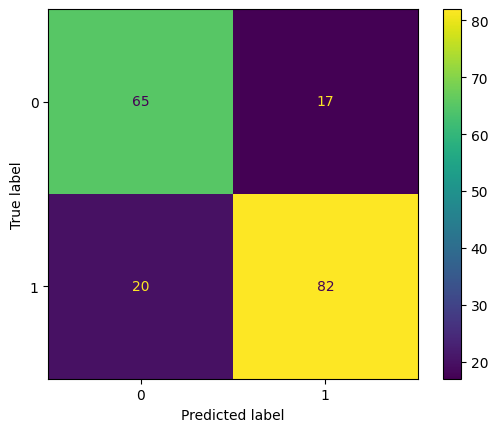

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        82
           1       0.83      0.80      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

Specificity:  {0.7926829268292683}
0.7983022477283597


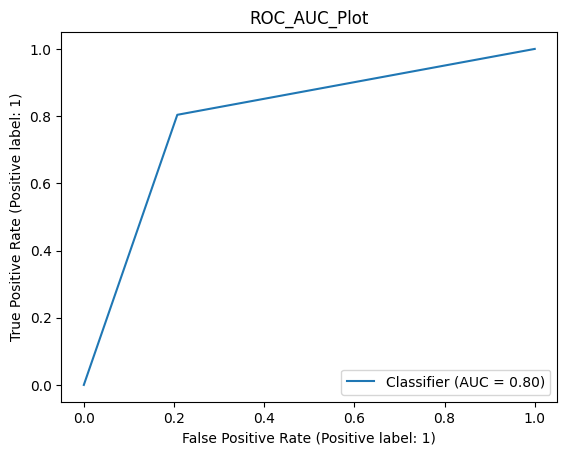

The Age Demographic Parity Difference is: 0.1759834368530021
The Age Demographic Parity Ratio is: 0.7301587301587301
The Sex Demographic Parity Difference is: 0.046666666666666634
The Sex Demographic Parity Ratio is: 0.9146341463414634
The Age Equalized Odds Difference is: 0.24242424242424243
The Age Equalized Odds Ratio is: 0.4047619047619047
The Sex Equalized Odds Difference is: 0.33597883597883593
The Sex Equalized Odds Ratio is: 0.21604938271604937


In [133]:
#----------------------------------- SUPPORT VECTOR MATRIX MODEL -------------------------------------------#
print('--------------------------Support Vector Matrix----------------------------------')
print('--------------------------With CORRELATION----------------------------------')
classifier_svc, y_pred, fair_pred, fair_model= model(SVC(kernel="linear", random_state=0, gamma = 10, C=10, probability= True), x_dev, x_test, y_dev, y_test)
#explain(shap.Explainer(classifier_svc), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_svc_sex, y_pred= modelpre(SVC(kernel="linear", random_state=0, gamma = 10, C=10, probability= True), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------Random Forest Vector--------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        37
           1       0.86      0.84      0.85        45

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

The accuracy for Fold 1 : 0.8411411411411411
The FAIR accuracy for Fold 1 : 0.706006006006006
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 2 : 0.8165165165165165
The FAIR accuracy for Fold 2 : 0.6972972972972973
The fold is : 2 : 
              precis

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


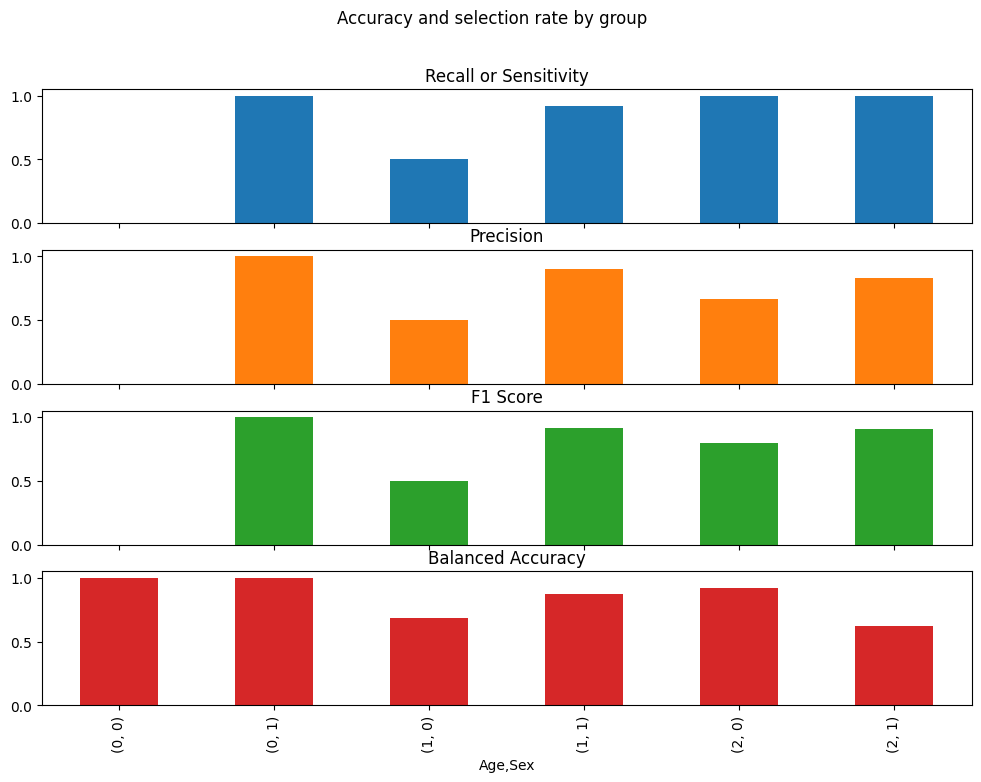

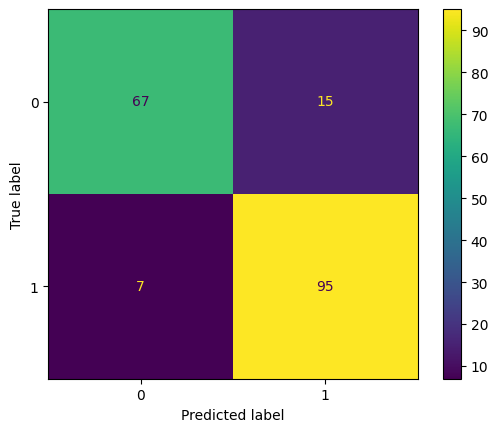

              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184

Specificity:  {0.8170731707317073}
0.8742228598756576


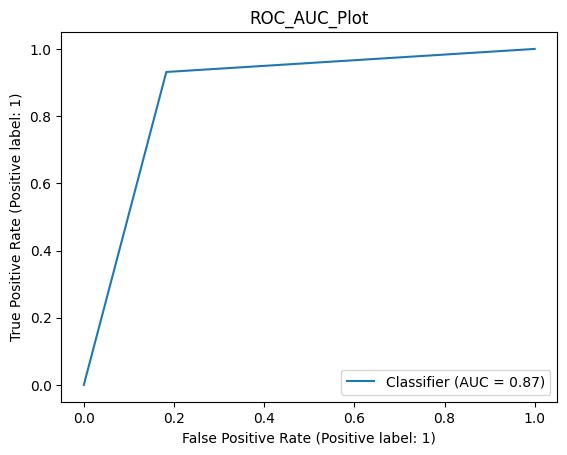

-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.872549
Precision                0.787611
F1 Score                 0.827907
Balanced Accuracy        0.789933
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.833333
    1                 1.000000   0.500000  0.666667           0.818182
1   0                 0.750000   0.250000  0.375000           0.593750
    1                 0.903226   0.888889  0.896000           0.851613
2   0                 1.000000   0.666667  0.800000           0.916667
    1                 0.800000   0.923077  0.857143           0.775000


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.5175438596491229
The Demographic Parity Ratio is: 0.24358974358974356
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


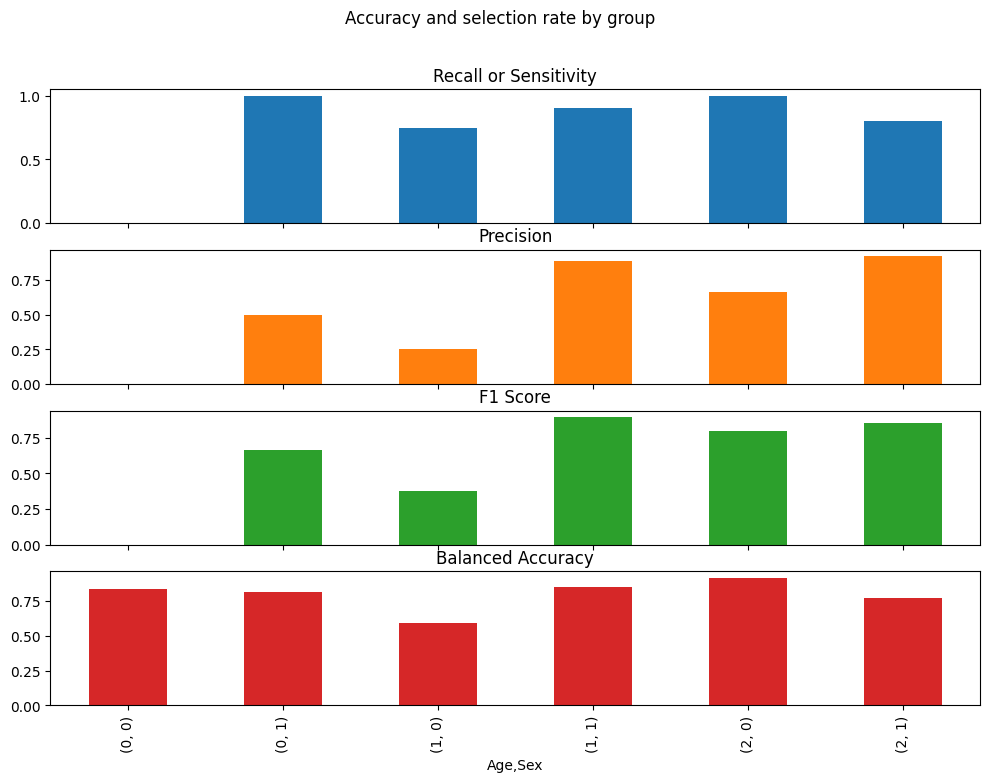

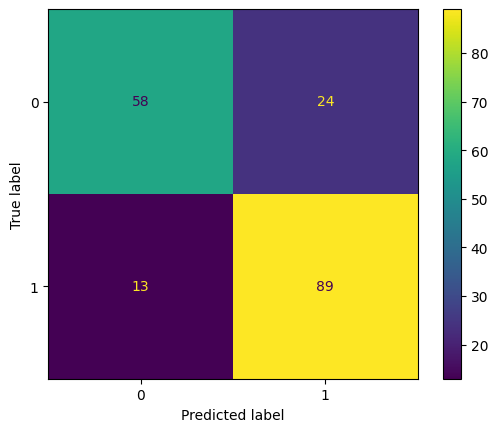

              precision    recall  f1-score   support

           0       0.82      0.71      0.76        82
           1       0.79      0.87      0.83       102

    accuracy                           0.80       184
   macro avg       0.80      0.79      0.79       184
weighted avg       0.80      0.80      0.80       184

Specificity:  {0.7073170731707317}
0.7899330463892874


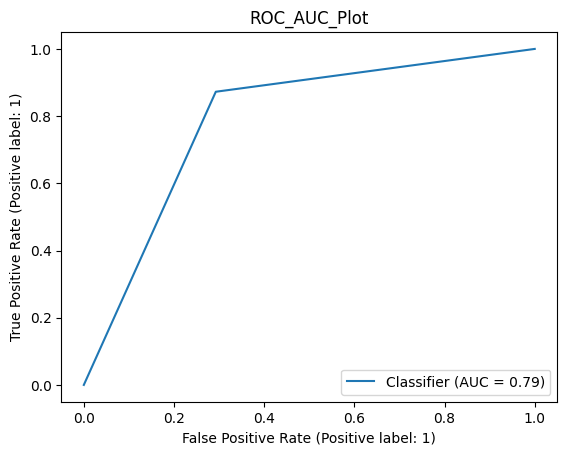

--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.81      0.78      0.79        37
           1       0.83      0.84      0.84        45

    accuracy                           0.82        82
   macro avg       0.82      0.81      0.81        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 1 : 0.8141141141141142
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.88      0.78      0.83        37
           1       0.84      0.91      0.87        45

    accuracy                           0.85        82
   macro avg       0.86      0.85      0.85        82
weighted avg       0.86      0.85      0.85        82

The accuracy for Fold 2 : 0.8474474474474474
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        37
          

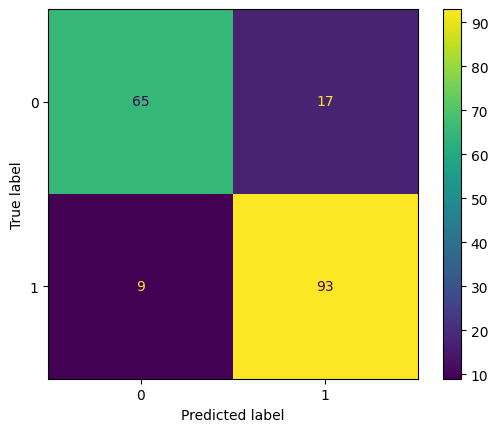

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184

Specificity:  {0.7926829268292683}
0.8522238163558106


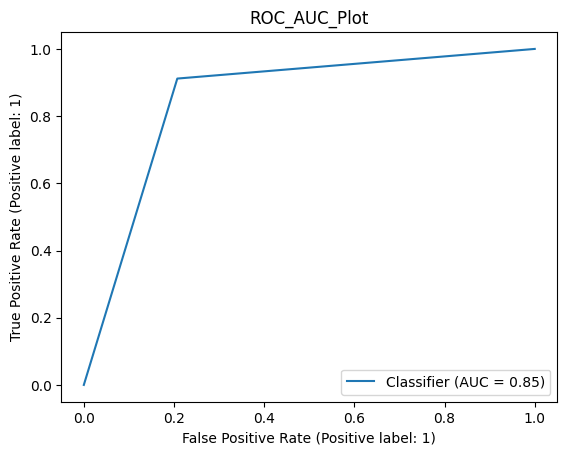

The Age Demographic Parity Difference is: 0.5186335403726708
The Age Demographic Parity Ratio is: 0.35521235521235517
The Sex Demographic Parity Difference is: 0.4807843137254902
The Sex Demographic Parity Ratio is: 0.2998286693318104
The Age Equalized Odds Difference is: 0.31092436974789917
The Age Equalized Odds Ratio is: 0.27450980392156865
The Sex Equalized Odds Difference is: 0.4375
The Sex Equalized Odds Ratio is: 0.5333333333333333


In [134]:
#-------------------------------------- RANDOM FOREST CLASSIFIER ----------------------------------------#
print('---------------------------Random Forest Vector--------------------------------')
classifier_rf, y_pred, fair_pred, fair_model= model(RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=5, max_depth=10), x_dev, x_test, y_dev, y_test)
#explain(shap.Explainer(classifier_rf), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_rf_fair, y_pred= modelpre(RandomForestClassifier(random_state=0, n_estimators=100, min_samples_split=5, max_depth=10),x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

In [139]:
#------------------------------------  K-NEAREST NEIGHBBOR ------------------------------------------#
print('-----------------------------K Nearest Neighbor-----------------------------')
classifier_knn, y_pred, fair_pred, fair_model= model(KNeighborsClassifier(n_neighbors=5), x_dev, x_test, y_dev, y_test)
#explain(shap.Explainer(classifier_knn), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_knn_fair, y_pred= modelpre(KNeighborsClassifier(n_neighbors=5), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

-----------------------------K Nearest Neighbor-----------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.78      0.81        37
           1       0.83      0.87      0.85        45

    accuracy                           0.83        82
   macro avg       0.83      0.83      0.83        82
weighted avg       0.83      0.83      0.83        82

The accuracy for Fold 1 : 0.8252252252252252


TypeError: fit() got an unexpected keyword argument 'sample_weight'

---------------------------------------Ada Boost-----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.74      0.86      0.80        37
           1       0.87      0.76      0.81        45

    accuracy                           0.80        82
   macro avg       0.81      0.81      0.80        82
weighted avg       0.81      0.80      0.81        82

The accuracy for Fold 1 : 0.8102102102102102
The FAIR accuracy for Fold 1 : 0.6282282282282282
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        37
           1       0.80      0.82      0.81        45

    accuracy                           0.79        82
   macro avg       0.79      0.79      0.79        82
weighted avg       0.79      0.79      0.79        82

The accuracy for Fold 2 : 0.7894894894894895
The FAIR accuracy for Fold 2 : 0.6774774774774776
The fold is : 2 : 
              precision    

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


The Demographic Parity Difference is: 0.5701754385964912
The Demographic Parity Ratio is: 0.2261904761904762
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


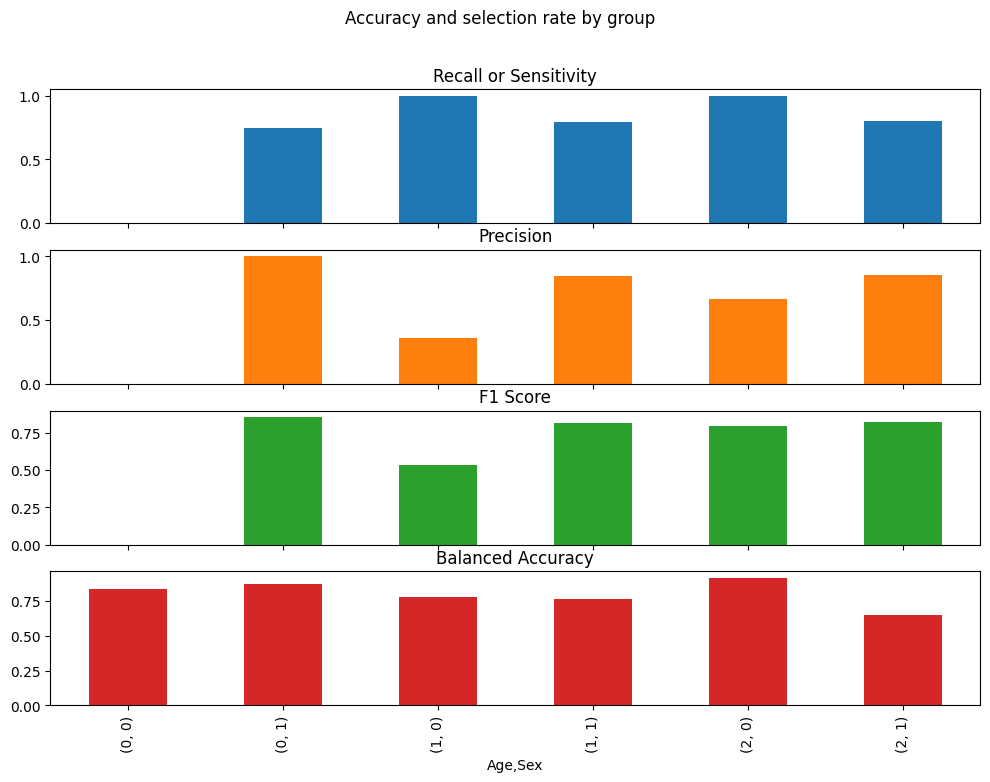

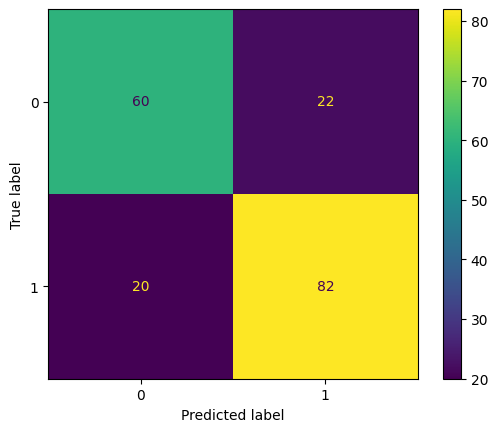

              precision    recall  f1-score   support

           0       0.75      0.73      0.74        82
           1       0.79      0.80      0.80       102

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.77       184
weighted avg       0.77      0.77      0.77       184

Specificity:  {0.7317073170731707}
0.7678144428503109


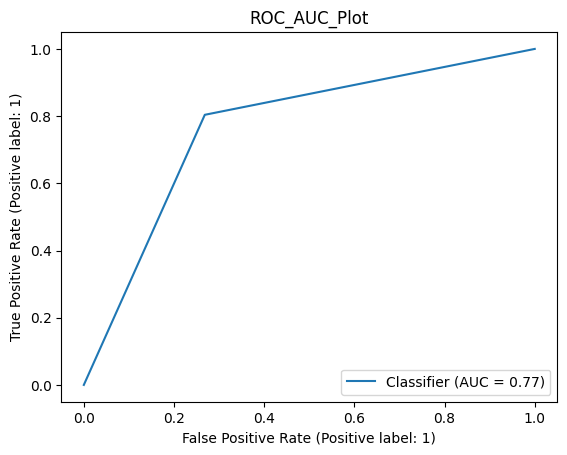

-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.647059
Precision                0.709677
F1 Score                 0.676923
Balanced Accuracy        0.658895
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.333333
    1                 1.000000   1.000000  1.000000           1.000000
1   0                 1.000000   0.333333  0.500000           0.750000
    1                 0.661290   0.773585  0.713043           0.659217
2   0                 0.500000   0.500000  0.500000           0.666667
    1                 0.533333   0.888889  0.666667           0.641667


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.41666666666666663
The Demographic Parity Ratio is: 0.375
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


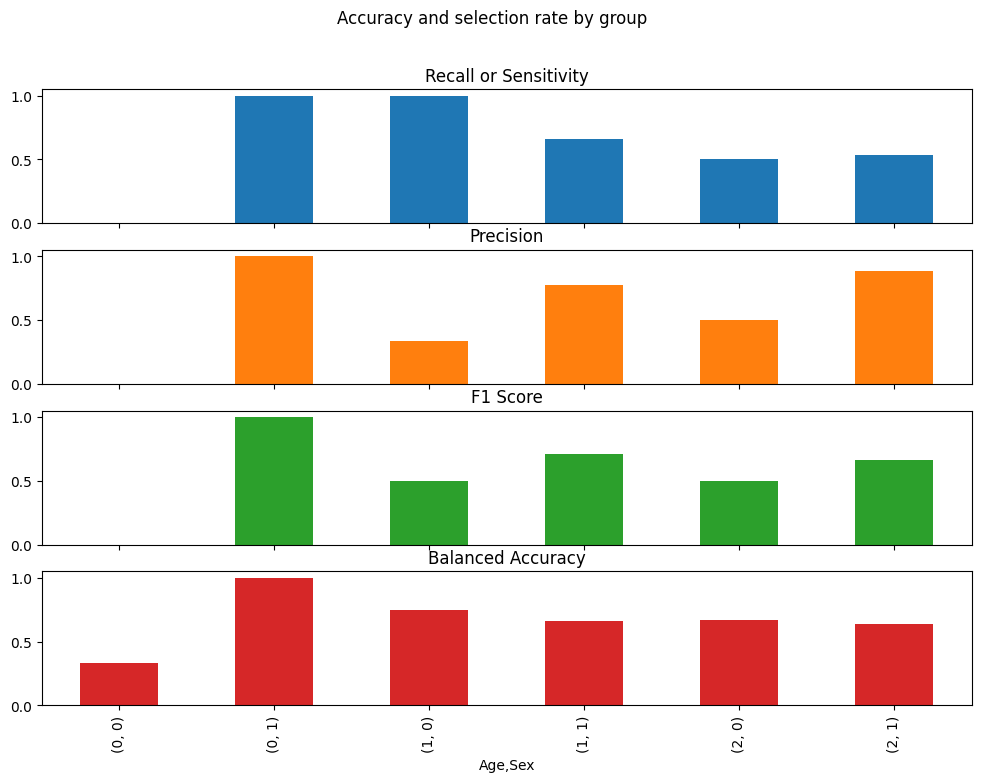

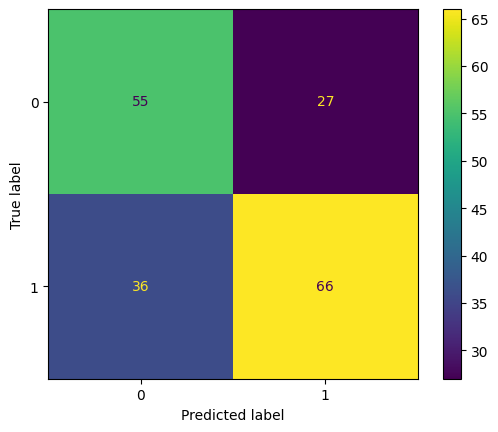

              precision    recall  f1-score   support

           0       0.60      0.67      0.64        82
           1       0.71      0.65      0.68       102

    accuracy                           0.66       184
   macro avg       0.66      0.66      0.66       184
weighted avg       0.66      0.66      0.66       184

Specificity:  {0.6707317073170732}
0.6588952654232424


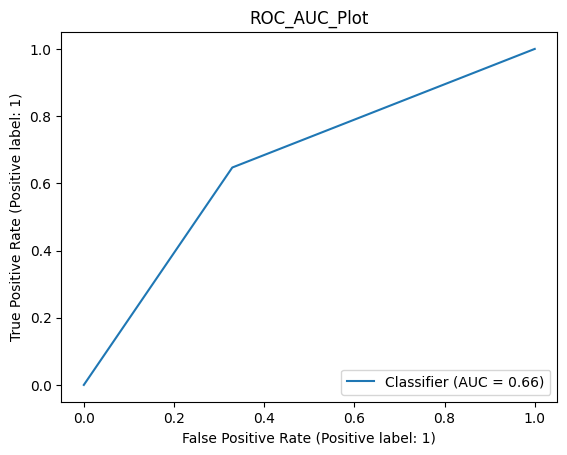

--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.65      0.89      0.75        37
           1       0.87      0.60      0.71        45

    accuracy                           0.73        82
   macro avg       0.76      0.75      0.73        82
weighted avg       0.77      0.73      0.73        82

The accuracy for Fold 1 : 0.745945945945946
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.64      0.92      0.76        37
           1       0.90      0.58      0.70        45

    accuracy                           0.73        82
   macro avg       0.77      0.75      0.73        82
weighted avg       0.78      0.73      0.73        82

The accuracy for Fold 2 : 0.7483483483483483
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        37
           

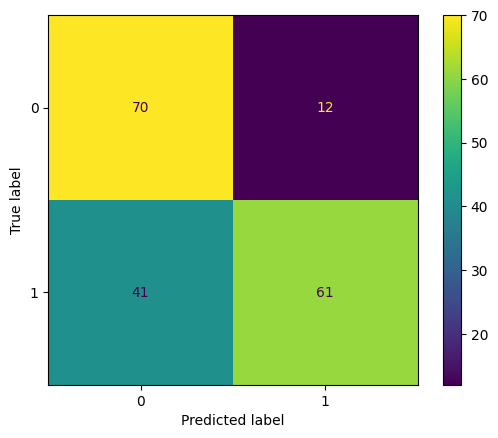

              precision    recall  f1-score   support

           0       0.63      0.85      0.73        82
           1       0.84      0.60      0.70       102

    accuracy                           0.71       184
   macro avg       0.73      0.73      0.71       184
weighted avg       0.74      0.71      0.71       184

Specificity:  {0.8536585365853658}
0.7258488761358202


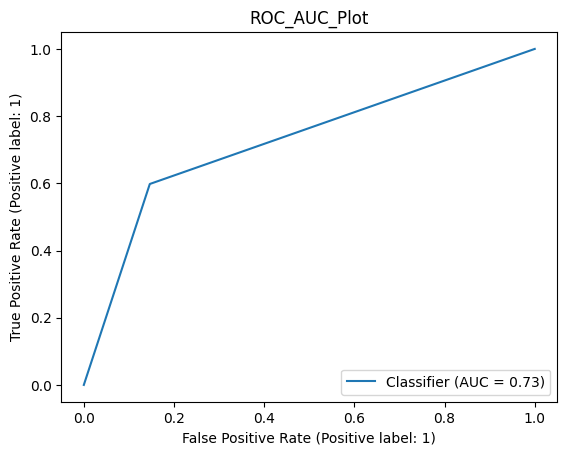

The Age Demographic Parity Difference is: 0.30952380952380953
The Age Demographic Parity Ratio is: 0.38095238095238093
The Sex Demographic Parity Difference is: 0.2701960784313725
The Sex Demographic Parity Ratio is: 0.39508340649692714
The Age Equalized Odds Difference is: 0.18939393939393945
The Age Equalized Odds Ratio is: 0.3333333333333333
The Sex Equalized Odds Difference is: 0.10416666666666663
The Sex Equalized Odds Ratio is: 0.6428571428571429


In [138]:
#-------------------------------------- ADABOOST ----------------------------------------#
# hyperparameter tuning
print('---------------------------------------Ada Boost-----------------------')
classifier_adab, y_pred, fair_pred, fair_model= model(AdaBoostClassifier(random_state=0, n_estimators=100, learning_rate=0.001), x_dev, x_test, y_dev, y_test )
#explain(shap.Explainer(classifier_adab), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_adab_fair, y_pred= modelpre(AdaBoostClassifier(random_state=0, n_estimators=100, learning_rate=0.001),x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------------------GradientBoostingClassifier-----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        37
           1       0.97      0.82      0.89        45

    accuracy                           0.89        82
   macro avg       0.90      0.90      0.89        82
weighted avg       0.90      0.89      0.89        82

The accuracy for Fold 1 : 0.8975975975975976
The FAIR accuracy for Fold 1 : 0.8117117117117117
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        37
           1       0.88      0.84      0.86        45

    accuracy                           0.85        82
   macro avg       0.85      0.85      0.85        82
weighted avg       0.86      0.85      0.85        82

The accuracy for Fold 2 : 0.8546546546546548
The FAIR accuracy for Fold 2 : 0.7648648648648648
The fold is : 2 : 
          

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.


The Equalized Odds Difference is: 0.9666666666666667
The Equalized Odds Ratio is: 0.0


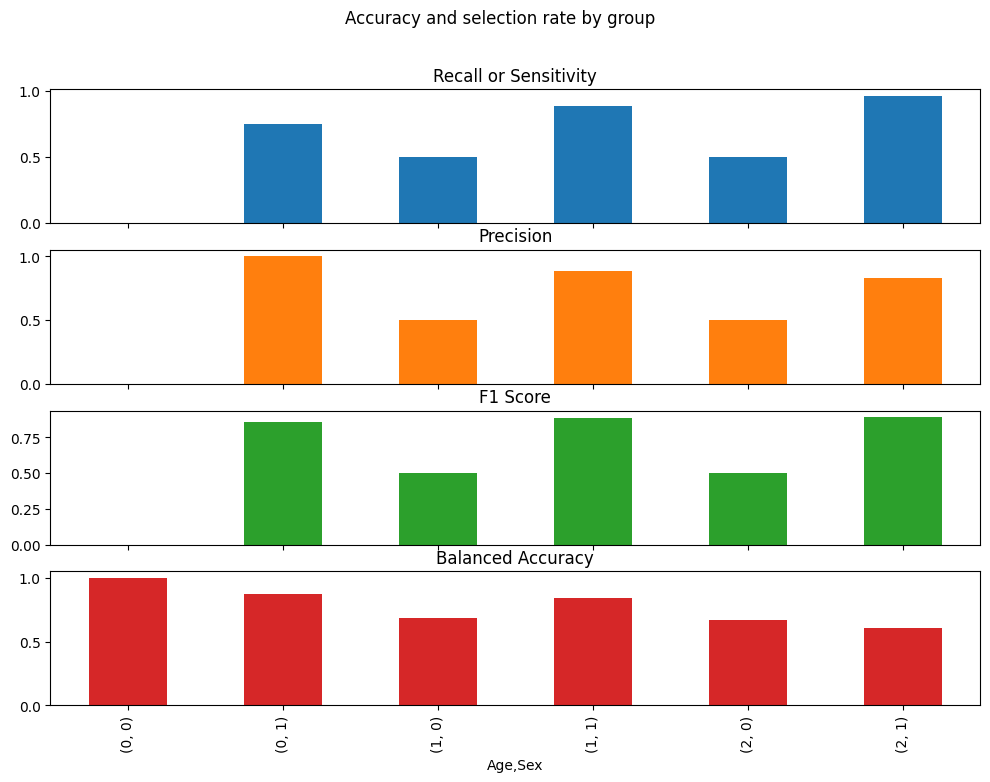

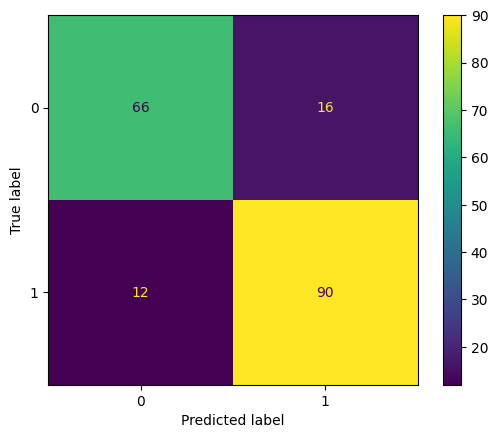

              precision    recall  f1-score   support

           0       0.85      0.80      0.83        82
           1       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184

Specificity:  {0.8048780487804879}
0.8436154949784792


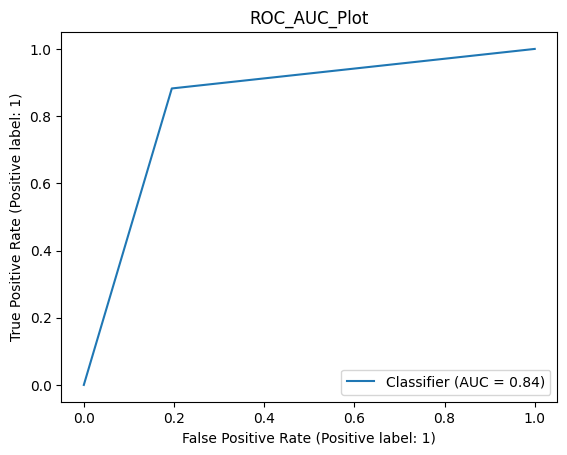

-----------------------Fair Model-------------------------
OVERALL METRICS
Recall or Sensitivity    0.745098
Precision                0.730769
F1 Score                 0.737864
Balanced Accuracy        0.701817
dtype: float64
METRIC BY GROUP
         Recall or Sensitivity  Precision  F1 Score  Balanced Accuracy
Age Sex                                                               
0   0                 0.000000   0.000000  0.000000           0.500000
    1                 1.000000   0.500000  0.666667           0.818182
1   0                 1.000000   0.285714  0.444444           0.687500
    1                 0.774194   0.857143  0.813559           0.772811
2   0                 1.000000   0.500000  0.666667           0.833333
    1                 0.600000   0.947368  0.734694           0.737500


Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
y_pred contains classes not in y_true


---------------------------------Both Sensitive Features Applied--------------------------------
The Demographic Parity Difference is: 0.19999999999999996
The Demographic Parity Ratio is: 0.7142857142857143
The Equalized Odds Difference is: 1.0
The Equalized Odds Ratio is: 0.0


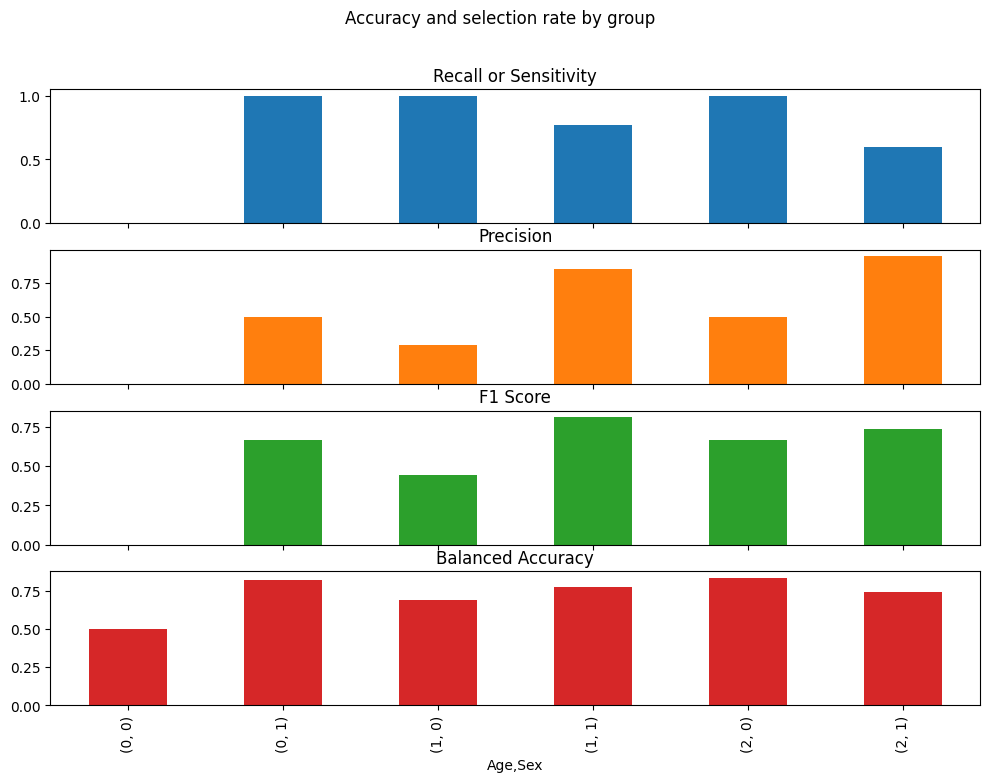

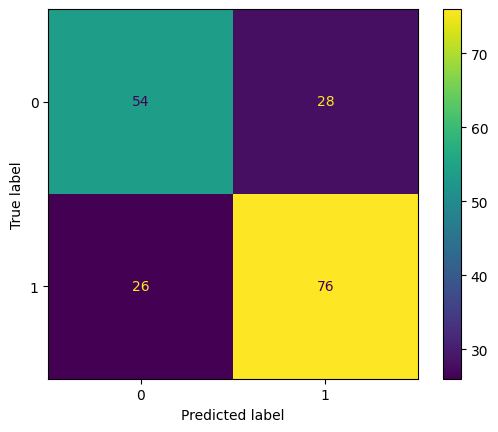

              precision    recall  f1-score   support

           0       0.68      0.66      0.67        82
           1       0.73      0.75      0.74       102

    accuracy                           0.71       184
   macro avg       0.70      0.70      0.70       184
weighted avg       0.71      0.71      0.71       184

Specificity:  {0.6585365853658537}
0.7018173122907699


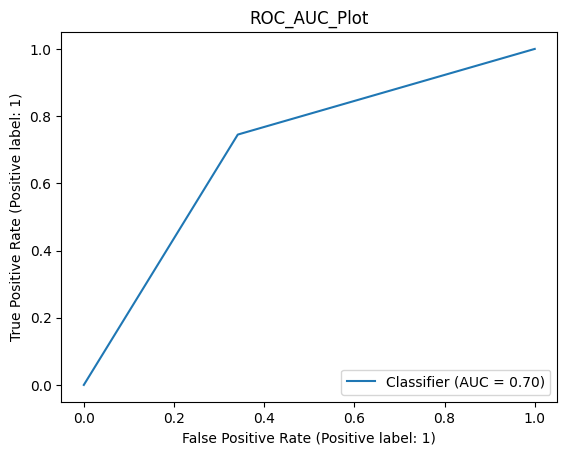

--------------------------Without CORRELATION----------------------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        37
           1       0.93      0.84      0.88        45

    accuracy                           0.88        82
   macro avg       0.88      0.88      0.88        82
weighted avg       0.88      0.88      0.88        82

The accuracy for Fold 1 : 0.8816816816816817
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.84      0.82      0.83        45

    accuracy                           0.82        82
   macro avg       0.82      0.82      0.82        82
weighted avg       0.82      0.82      0.82        82

The accuracy for Fold 2 : 0.8165165165165165
The fold is : 2 : 
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        37
          

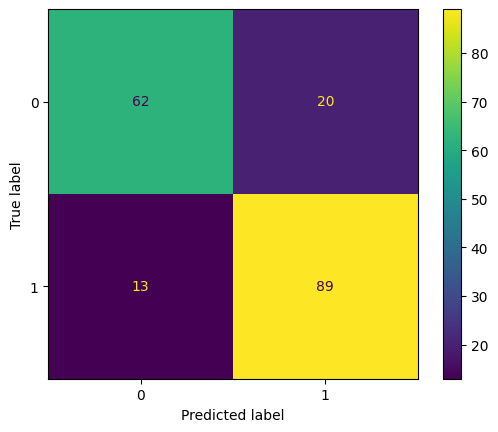

              precision    recall  f1-score   support

           0       0.83      0.76      0.79        82
           1       0.82      0.87      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184

Specificity:  {0.7560975609756098}
0.8143232902917265


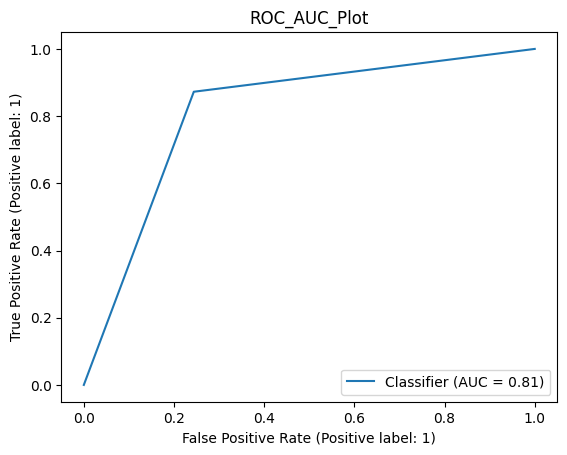

The Age Demographic Parity Difference is: 0.5186335403726708
The Age Demographic Parity Ratio is: 0.35521235521235517
The Sex Demographic Parity Difference is: 0.4380392156862745
The Sex Demographic Parity Ratio is: 0.34944670937682004
The Age Equalized Odds Difference is: 0.31092436974789917
The Age Equalized Odds Ratio is: 0.27450980392156865
The Sex Equalized Odds Difference is: 0.21875
The Sex Equalized Odds Ratio is: 0.48214285714285715


In [137]:
#-------------------------------------- GRADIENT BOOSTING CLASSIFIER ----------------------------------------#
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
print('---------------------------------------GradientBoostingClassifier-----------------------')
classifier_gbc, y_pred, fair_pred, fair_model= model(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), x_dev, x_test, y_dev, y_test )
#explain(shap.Explainer(classifier_gbc), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_gbc_fair, y_pred= modelpre(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

In [136]:
#-------------------------------------- MULTI-lAYER PERCEPRTION ----------------------------------------#
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
print('---------------------------------------MLP Classifier----------------------')
classifier_mlp, y_pred, fair_pred, fair_model= model(MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=9, hidden_layer_sizes=(5, 2), random_state=1), x_dev, x_test, y_dev, y_test )
#explain(shap.Explainer(classifier_mlp), x_test)

print('--------------------------Without CORRELATION----------------------------------')
classifier_mlp_fair, y_pred= modelpre(MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), x_dev_fair, x_test_fair, y_dev_fair, y_test_fair, x_test)

---------------------------------------MLP Classifier----------------------
The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        37
           1       0.88      0.82      0.85        45

    accuracy                           0.84        82
   macro avg       0.84      0.84      0.84        82
weighted avg       0.84      0.84      0.84        82

The accuracy for Fold 1 : 0.8435435435435436


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


TypeError: fit() got an unexpected keyword argument 'sample_weight'

# Explain away
Shapley values

In [112]:
print('--------------------------Logistic Regression---------------------------------')
explain(shap.LinearExplainer(classifier_lr), x_test)

--------------------------Logistic Regression---------------------------------


TypeError: __init__() missing 1 required positional argument: 'masker'

In [ ]:


print('--------------------------Support Vector Matrix----------------------------------')
explain(shap.Explainer(classifier_svc), x_test)

print('---------------------------Random Forest Vector--------------------------------')
explain(shap.Explainer(classifier_rf), x_test)

print('---------------------------------------GradientBoostingClassifier-----------------------')
explain(shap.Explainer(classifier_gbc), x_test)

print('---------------------------------------Ada Boost-----------------------')
explain(shap.Explainer(classifier_adab), x_test)

print('---------------------------------------MLP Classifier----------------------')
explain(shap.Explainer(classifier_mlp), x_test)

print('-----------------------------K Nearest Neighbor-----------------------------')
explain(shap.Explainer(classifier_knn), x_test)

## References
General resources used during development of the model.
Kaggle notebooks:
* Heart Disease Prediction using 9 models: https://kaggle.com/code/fahadrehman07/heart-disease-prediction-using-9-models
* https://kaggle.com/code/tanmay111999/heart-failure-prediction-cv-score-90-5-models
* https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem
* https://www.kaggle.com/code/durgancegaur/data-imbalance-eda-87-auc?scriptVersionId=88319036
Bias Mitigation
* https://fairlearn.org/main/auto_examples/plot_correlationremover_before_after.html

SHAP values
***
Models
* Gradient Boosting: # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
* MLP # https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised
**